# GEE and GLMM; interpretation of marginal parameters in logistic regression models; missing data

We'll fit models with general estimating equations (`gee`) and general linear mixed models (`lme4`).

In [1]:
library(data.table)
library(gee)
library(lme4)
library(tools)
library(xtable)

Loading required package: Matrix


## Fluoride Data

In [2]:
head(fluoride.data <- data.table(read.csv('fluoride.csv'), key='id'))

id,age,income,fluoride,fl
2,3.0,1,0.00000000,FALSE
2,6.0,1,0.05063998,TRUE
2,9.0,1,0.04779446,FALSE
3,1.5,0,0.11742604,TRUE
3,3.0,0,0.08832044,TRUE
3,6.0,0,0.06216184,TRUE


In [3]:
summary(fluoride.data)

       id            age            income          fluoride       
 Min.   :   2   Min.   :1.500   Min.   :0.0000   Min.   :0.000000  
 1st Qu.: 444   1st Qu.:1.500   1st Qu.:0.0000   1st Qu.:0.008185  
 Median : 934   Median :3.000   Median :1.0000   Median :0.048175  
 Mean   : 929   Mean   :4.675   Mean   :0.6382   Mean   :0.067876  
 3rd Qu.:1409   3rd Qu.:6.000   3rd Qu.:1.0000   3rd Qu.:0.104724  
 Max.   :1886   Max.   :9.000   Max.   :1.0000   Max.   :1.794320  
     fl         
 Mode :logical  
 FALSE:1966     
 TRUE :1898     
                
                
                

## Fluoride Data with Missing Entries

In [4]:
head(fluoride.miss.data <- data.table(read.csv('fluoride.miss.csv'), key='id'))

id,age,income,fluoride,fl
2,3.0,1,0.00000000,FALSE
2,6.0,1,0.05063998,TRUE
2,9.0,1,0.04779446,FALSE
3,3.0,0,0.08832044,TRUE
3,6.0,0,0.06216184,TRUE
4,1.5,1,0.03531871,FALSE


In [5]:
summary(fluoride.miss.data)

       id              age            income          fluoride       
 Min.   :   2.0   Min.   :1.500   Min.   :0.0000   Min.   :0.000000  
 1st Qu.: 485.0   1st Qu.:3.000   1st Qu.:1.0000   1st Qu.:0.006707  
 Median : 975.0   Median :3.000   Median :1.0000   Median :0.042219  
 Mean   : 954.9   Mean   :4.709   Mean   :0.7811   Mean   :0.064560  
 3rd Qu.:1431.0   3rd Qu.:6.000   3rd Qu.:1.0000   3rd Qu.:0.100249  
 Max.   :1886.0   Max.   :9.000   Max.   :1.0000   Max.   :1.794320  
     fl         
 Mode :logical  
 FALSE:1679     
 TRUE :1478     
                
                
                

## Models

### General Estimating Equations (GEE)

In [6]:
gee.age.independent <- gee(fl ~ age, id=id,
                           family=binomial,
                           data=fluoride.data)
gee.age.exchangeable <- update(gee.age.independent, corstr='exchangeable')
gee.interaction.independent <- update(gee.age.independent, formula=.~. + income + age:income)
gee.interaction.exchangeable <- update(gee.interaction.independent, corstr='exchangeable')

Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)          age 
-0.024537225 -0.002280917 


Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)          age 
-0.024537225 -0.002280917 


Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)         age      income  age:income 
 0.57645733 -0.04872948 -0.96444671  0.07683365 


Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)         age      income  age:income 
 0.57645733 -0.04872948 -0.96444671  0.07683365 


### General Linear Mixed Models (GLMM)

In [7]:
glmm.age <- glmer(fl ~ age + (1|id), family=binomial, data=fluoride.data)
glmm.interaction <- update(glmm.age, formula=.~. + income + age:income)

### Missing Data and GEE

In [8]:
gee.age.independent.miss <- update(gee.age.independent, data=fluoride.miss.data)
gee.age.exchangeable.miss <- update(gee.age.exchangeable, data=fluoride.miss.data)
gee.interaction.independent.miss <- update(gee.interaction.independent, data=fluoride.miss.data)
gee.interaction.exchangeable.miss <- update(gee.interaction.exchangeable, data=fluoride.miss.data)

Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)          age 
-0.165918518  0.008153993 


Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)          age 
-0.165918518  0.008153993 


Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)         age      income  age:income 
 0.59166829 -0.05778955 -0.97965768  0.08589372 


Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)         age      income  age:income 
 0.59166829 -0.05778955 -0.97965768  0.08589372 


### Missing Data and GLMM

In [9]:
glmm.age.miss <- update(glmm.age, data=fluoride.miss.data)
glmm.interaction.miss <- update(glmm.interaction, data=fluoride.miss.data)

### Estimates and Standard Errors

In [10]:
summarize.model <- function(model) {
    coefficients <- summary(model)$coefficients
    standard.error <- if (is(model, 'gee')) {
        coefficients[,'Robust S.E.']
    } else if (is(model, 'glmerMod')) {
        coefficients[,'Std. Error']
    }
    data.frame(coefficient=row.names(coefficients),
               estimate=coefficients[,'Estimate'],
               standard.error=standard.error,
               row.names=NULL)    
}

In [11]:
key.model <- function(model) {
    data.frame(
        correlation.structure=if (is(model, 'gee')) {
            if (is.null(getCall(model)$corstr)) {
                'GEE Independent'
            } else {
                paste('GEE', toTitleCase(getCall(model)$corstr))
            }
        } else if (is(model, 'glmerMod')) {
            'Mixed Model'
        },
        has.interaction=nrow(summary(model)$coefficients) == 4,
        is.missing=getCall(model)$data == quote(fluoride.miss.data)
    )
}

In [12]:
model.summaries <- do.call(rbind, lapply(list(
    gee.age.independent, gee.age.exchangeable, glmm.age,
    gee.interaction.independent, gee.interaction.exchangeable, glmm.interaction,
    gee.age.independent.miss, gee.age.exchangeable.miss, glmm.age.miss,
    gee.interaction.independent.miss, gee.interaction.exchangeable.miss, glmm.interaction.miss),
       function(model) {
           cbind(key.model(model), summarize.model(model))
       }))

write.csv(model.summaries, file='model_summaries.csv', row.names=FALSE)

In [72]:
data.frame(list(a=c(p=1), b=c(p=2), c=c(p=3)))

,a,b,c
p,1,2,3


### Confidence Intervals

In [81]:
make.intervals <- function(model, indicator, confidence=0.95) {
    beta <- if (is(model, 'gee')) {
        coef(model)
    } else if (is(model, 'glmerMod')) {
        fixef(model)
    }
    sigma <- if (is(model, 'gee')) {
        model$robust.variance
    } else if (is(model, 'glmerMod')) {
        vcov(model)
    }
    sigma <- sqrt(as.numeric(t(indicator) %*% sigma %*% indicator))
    z <- qnorm((1 - confidence)/2)
    estimate <- beta %*% indicator
    c(`Point Estimate`=estimate,
      `95\\% CI lower bound`=z*sigma + estimate,
      `95\\% CI upper bound`=-z*sigma + estimate)
}

In [85]:
interaction.models <- list(
    `GEE Independent`=gee.interaction.independent,
    `GEE Exchangeable`=gee.interaction.exchangeable,
    `Mixed Model`=glmm.interaction)

beta.1.intervals <- t(data.frame(
    lapply(interaction.models, make.intervals, indicator=c(0, 1, 0, 0)), check.names=FALSE))
beta.1.3.intervals <- t(data.frame(
    lapply(interaction.models, make.intervals, indicator=c(0, 1, 0, 1)), check.names=FALSE))

t(data.frame(beta.1.3.intervals, check.names=FALSE))

,Point Estimate,95\% CI lower bound,95\% CI upper bound
GEE Independent,0.02810417,0.001156858,0.05505148
GEE Exchangeable,0.03829750,0.012228442,0.06436657
Mixed Model,0.07686298,0.034625919,0.11910004


In [77]:
qnorm(0.975)

[1] 1.959964

In [49]:
fixef(glmm.interaction)

(Intercept)         age      income  age:income 
 1.17150572 -0.05463762 -2.08389003  0.13150060

In [59]:
gee.interaction.exchangeable$robust.variance

,(Intercept),age,income,age:income
(Intercept),0.013229171,-0.0014854833,-0.013229171,0.0014854833
age,-0.001485483,0.0003109571,0.001485483,-0.0003109571
income,-0.013229171,0.0014854833,0.021165501,-0.0023522817
age:income,0.001485483,-0.0003109571,-0.002352282,0.0004878680


In [71]:
sqrt(0.0003109571 + 0.0004878680 + 2*-0.0003109571)

[1] 0.01330079

In [18]:
library(ggplot2)

summary(glmm.interaction)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: fl ~ age + (1 | id) + income + age:income
   Data: fluoride.data

     AIC      BIC   logLik deviance df.resid 
  4400.0   4431.3  -2195.0   4390.0     3859 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8756 -0.3617 -0.2414  0.3742  1.8974 

Random effects:
 Groups Name        Variance Std.Dev.
 id     (Intercept) 7.138    2.672   
Number of obs: 3864, groups:  id, 1279

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.17151    0.20896   5.606 2.07e-08 ***
age         -0.05464    0.02944  -1.856 0.063463 .  
income      -2.08389    0.26976  -7.725 1.12e-14 ***
age:income   0.13150    0.03651   3.602 0.000316 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr) age    income
age        -0.628              
income     -0.802  0.488       
a

In [27]:
summary(gee.interaction.exchangeable)


 GEE:  GENERALIZED LINEAR MODELS FOR DEPENDENT DATA
 gee S-function, version 4.13 modified 98/01/27 (1998) 

Model:
 Link:                      Logit 
 Variance to Mean Relation: Binomial 
 Correlation Structure:     Exchangeable 

Call:
gee(formula = fl ~ age + income + age:income, id = id, data = fluoride.data, 
    family = binomial, corstr = "exchangeable")

Summary of Residuals:
       Min         1Q     Median         3Q        Max 
-0.6199067 -0.4524910 -0.4102457  0.5189206  0.5897543 


Coefficients:
               Estimate Naive S.E.   Naive z Robust S.E.  Robust z
(Intercept)  0.52451986 0.10039101  5.224769  0.11501814  4.560323
age         -0.02357841 0.01413143 -1.668508  0.01763398 -1.337101
income      -0.94491592 0.12689169 -7.446634  0.14548368 -6.494996
age:income   0.06187591 0.01744399  3.547119  0.02208773  2.801370

Estimated Scale Parameter:  1.004703
Number of Iterations:  3

Working Correlation
          [,1]      [,2]      [,3]      [,4]
[1,] 1.0000000 0.533

In [30]:
sqrt(diag(gee.interaction.exchangeable$robust.variance))

(Intercept)         age      income  age:income 
 0.11501814  0.01763398  0.14548368  0.02208773

Warning message:
“Removed 151 rows containing missing values (geom_path).”

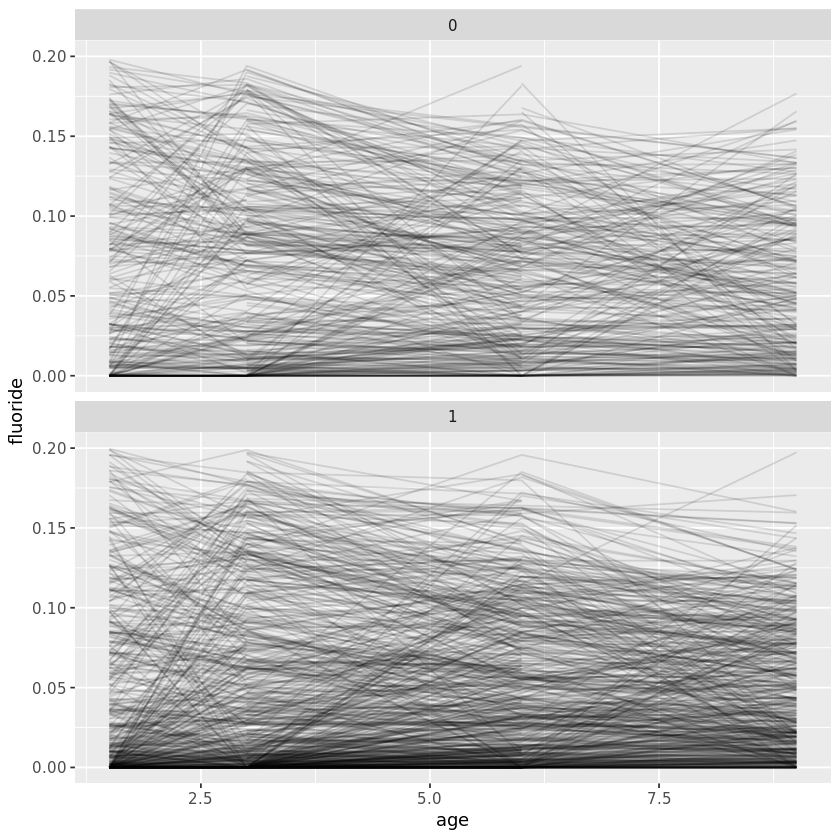

In [25]:
ggplot(fluoride.data, aes(age, fluoride, group=id)) +
  geom_line(alpha=0.125) +
  facet_wrap(~income, ncol=1) + 
  scale_y_continuous(limits=c(0, 0.2))